## Imports

In [359]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

import numpy as np
import math
import random

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import cm

## Dataset generation

In [321]:
def create_savings(nr_of_queries, nr_of_plans):
    savings = {}
    nr_of_plans_each = int(nr_of_plans / nr_of_queries)
    for j in range(nr_of_plans):
        current_query = math.floor(j / nr_of_plans_each)
        first_plan_next_query = (current_query + 1) * nr_of_plans_each
        for i in range(first_plan_next_query, nr_of_plans):
            savings[j, i] = random.randint(-20, 0)

    return savings

In [322]:
n_problems = 150
problems = []

n_qubits = 4
n_plans = 2
n_queries = int(n_qubits/n_plans)

cost_min = 0
cost_max = 50


for i in range(n_problems):
    problems.append((n_queries, np.random.randint(cost_min, cost_max, n_qubits), create_savings(n_queries, n_qubits)))

In [323]:
problems[0:5]

[(2,
  array([23,  1, 23,  6]),
  {(0, 2): 0, (0, 3): -5, (1, 2): -14, (1, 3): -15}),
 (2,
  array([11,  2, 33,  7]),
  {(0, 2): -4, (0, 3): -5, (1, 2): -14, (1, 3): -3}),
 (2,
  array([40,  4, 16,  6]),
  {(0, 2): -8, (0, 3): -15, (1, 2): -17, (1, 3): -16}),
 (2,
  array([ 0,  9,  3, 17]),
  {(0, 2): -20, (0, 3): -2, (1, 2): -11, (1, 3): -13}),
 (2, array([16, 33,  0, 28]), {(0, 2): -2, (0, 3): -9, (1, 2): -1, (1, 3): 0})]

## Circuit design for ML approach

This function plots the bloch sphere

In [324]:
def plot_bloch_sphere(circuit):
    state = Statevector.from_instruction(circuit)
    display(plot_bloch_multivector(state))

Generate a scaler that calculates down the cost to a range of $\left[-\frac{\pi}{2},-\frac{\pi}{2}\right]$

In [325]:
def scale(features):
    scaler = MinMaxScaler((-np.pi/4,np.pi/4))
    return scaler.fit_transform(features)

To fit the scaler we need to extract all values out of the dataset.

In [326]:
def extract_values(dataset):
    values = []
    for row in dataset:
        values.append(
            np.concatenate((row[1].tolist(),list(row[2].values())))
            )
    return np.array(values)

As we do not know which combination of the plans leads to the optimal result, all plans have an equal probability of being taken. Therefor, we set all qubits to the state $|+\rangle$, which corresponds to $\frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle$

In [327]:
def probability_principle(circuit):
    circuit.h(range(circuit.width()))
    circuit.barrier()

Our plans have an innate cost to them, which have to be applied to each of them. 

In [328]:
def plan_costs(costs, circuit):
    for i, cost in enumerate(costs):
        circuit.ry(-cost, i)
    circuit.barrier()

The combination of plans leads to cost savings when executing them together. Therefor, we want to apply these savings onto the circuits. As we do not know, if CRY or CRZ is better, we will offer the possibility to do both.

In [329]:
def combination_savings(savings, circuit):
    for i, saves in enumerate(savings):
        print(i)
        circuit.crz(-saves[0], i, n_plans)
        circuit.crz(-saves[1], i, 1+n_plans)
    circuit.barrier()
    

Now we need to add the gates that have trainable parameters.

In [330]:
def trainable_weights(weights, circuit):
    for i, weight in enumerate(weights):
        circuit.rx(weight, i)
    circuit.barrier()

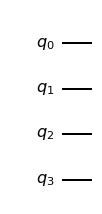

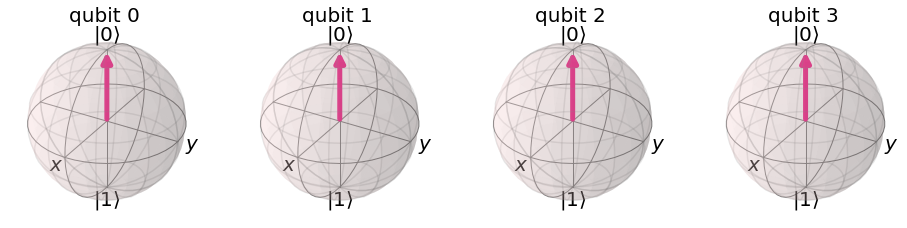

In [331]:
circuit = QuantumCircuit(n_qubits)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

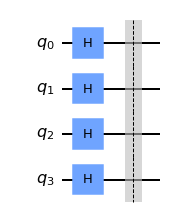

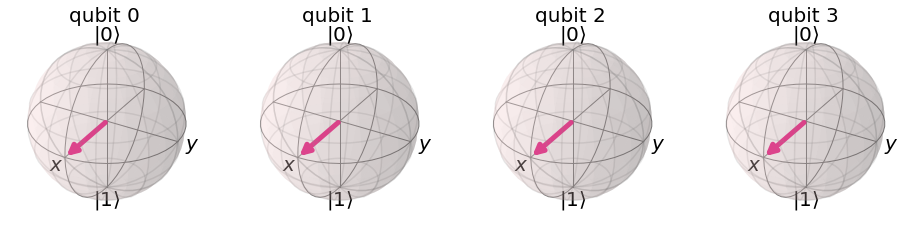

In [332]:
probability_principle(circuit)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

In [333]:
values = extract_values(problems)
t_values = scale(values[0].reshape(-1,1))


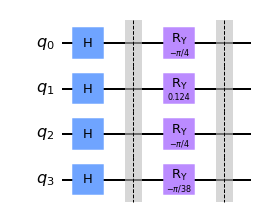

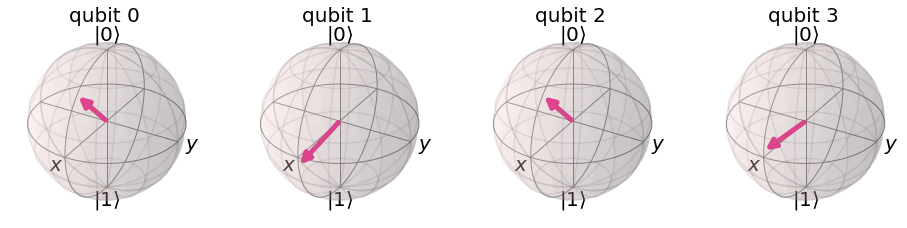

In [334]:
plan_costs(t_values[0:4].flatten(), circuit)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

0
1


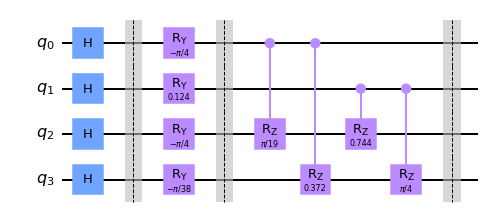

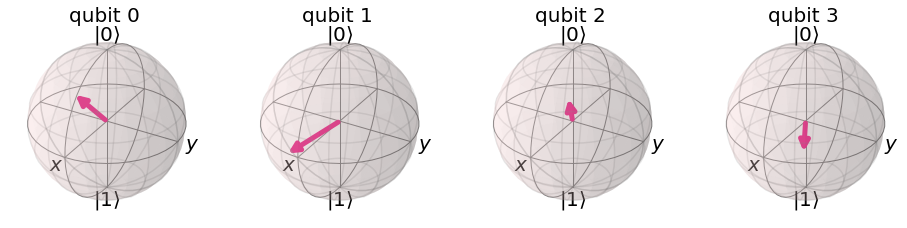

In [335]:
combination_savings(t_values[4:].reshape(n_plans,n_queries), circuit)
display(circuit.draw('mpl'))
plot_bloch_sphere(circuit)

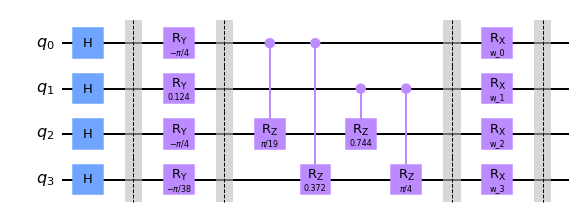

In [337]:
params = []
for i in range(n_qubits):
    params.append(Parameter('w_' + str(i)))
trainable_weights(params, circuit)
display(circuit.draw('mpl'))

## Visualizing the dataset

In [340]:
n_values = []
for value in values:
    n_values.append(scale(value.reshape(-1,1)))

In [386]:
def to_plot_axes(values):
    x = []
    y = []
    z = []
    for entry in values:
        x.append(entry[0])
        y.append(entry[2])
        z.append(entry[0] + entry[2] + entry[n_qubits])
        
        x.append(entry[0])
        y.append(entry[3])
        z.append(entry[0] + entry[3] + entry[n_qubits])

        x.append(entry[1])
        y.append(entry[2])
        z.append(entry[1] + entry[2] + entry[n_qubits])

        
        x.append(entry[1])
        y.append(entry[3])
        z.append(entry[1] + entry[3] + entry[n_qubits])
    return x, y, z

In [387]:
x, y, z = to_plot_axes(values)
x_s, y_s, z_s = to_plot_axes(n_values)

Now we plot the normalized problems!

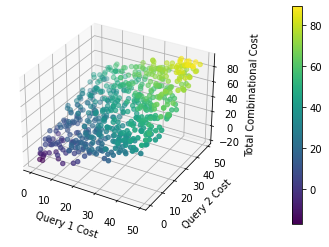

In [388]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot = ax.scatter(x, y, z, c=z)
cb = plt.colorbar(plot, pad=0.2)
ax.set_xlabel('Query 1 Cost')
ax.set_ylabel('Query 2 Cost')
ax.set_zlabel('Total Combinational Cost')
plt.show()

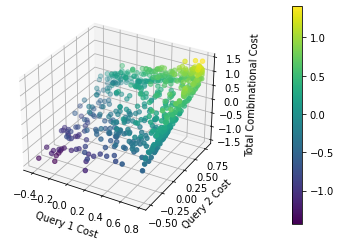

In [389]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot = ax.scatter(x_s, y_s, z_s, c=z_s)
cb = plt.colorbar(plot, pad=0.2)
ax.set_xlabel('Query 1 Cost')
ax.set_ylabel('Query 2 Cost')
ax.set_zlabel('Total Combinational Cost')
plt.show()